In [ ]:
import zipfile
path_to_zip_file = '/content/datadenek2.zip'
directory_to_extract_to = '/content'
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

87910968/87910968 [==============================] - 0s 0us/step
Epoch 1/30
65/64 [==============================] - ETA: 0s - loss: 7.9156 - accuracy: 0.8176
Epoch 1: val_accuracy improved from -inf to 0.89796, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


64/64 [==============================] - 31s 246ms/step - loss: 7.9156 - accuracy: 0.8176 - val_loss: 7.0200 - val_accuracy: 0.8980 - lr: 1.0000e-04
Epoch 2/30
65/64 [==============================] - ETA: 0s - loss: 6.3652 - accuracy: 0.9042
Epoch 2: val_accuracy improved from 0.89796 to 0.91950, saving model to best_model.h5
64/64 [==============================] - 11s 174ms/step - loss: 6.3652 - accuracy: 0.9042 - val_loss: 5.6508 - val_accuracy: 0.9195 - lr: 1.0000e-04
Epoch 3/30
65/64 [==============================] - ETA: 0s - loss: 5.1248 - accuracy: 0.9217
Epoch 3: val_accuracy improved from 0.91950 to 0.93311, saving model to best_model.h5
64/64 [==============================] - 11s 179ms/step - loss: 5.1248 - accuracy: 0.9217 - val_loss: 4.5614 - val_accuracy: 0.9331 - lr: 1.0000e-04
Epoch 4/30
65/64 [==============================] - ETA: 0s - loss: 4.1091 - accuracy: 0.9397
Epoch 4: val_accuracy improved from 0.93311 to 0.93764, saving model to best_model.h5
64/64 [======

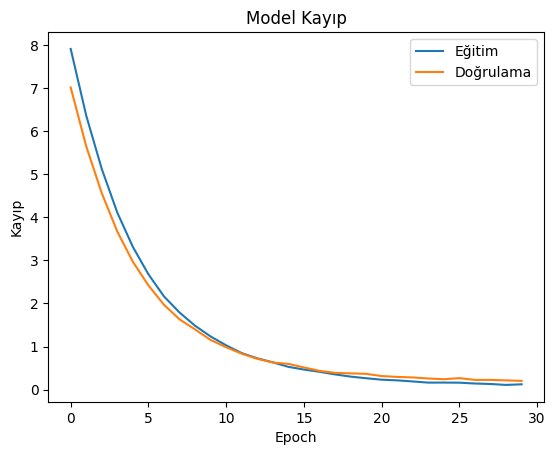

28/28 [==============================] - 2s 26ms/step
Kesinlik: 0.95
Hatırlama: 0.95
F1 Skoru: 0.95


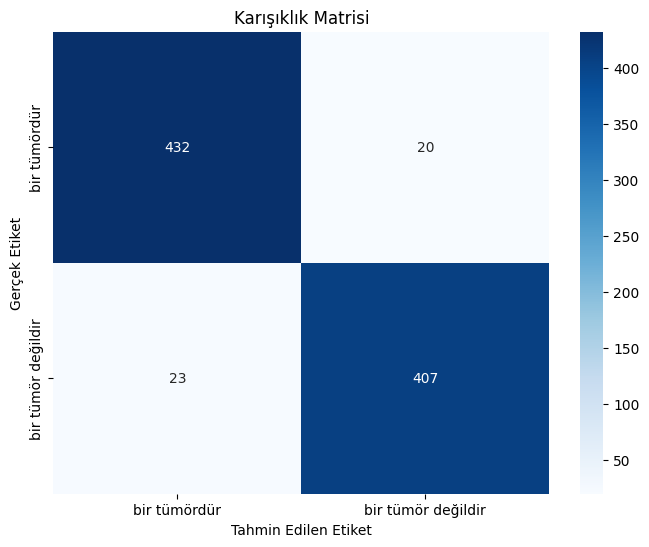

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, Model, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

train_yes_path = '/content/content/datadenek2/beyin/veri/yes1'
train_no_path = '/content/content/datadenek2/beyin/veri/no1'

data = []
labels = []

for r, d, f in os.walk(train_yes_path):
    for file in f:
        if file.endswith('.jpg'):
            img_path = os.path.join(r, file)
            img = Image.open(img_path)
            img = img.resize((128, 128))
            img = np.array(img)
            if img.shape == (128, 128, 3):
                data.append(img)
                labels.append(0)

for r, d, f in os.walk(train_no_path):
    for file in f:
        if file.endswith('.jpg'):
            img_path = os.path.join(r, file)
            img = Image.open(img_path)
            img = img.resize((128, 128))
            img = np.array(img)
            if img.shape == (128, 128, 3):
                data.append(img)
                labels.append(1)

if len(data) == 0 or len(labels) == 0:
    raise ValueError("Veriler veya etiketler boş. Lütfen veri yükleme sürecini kontrol edin.")

data = np.array(data)
labels = np.array(labels)

encoder = OneHotEncoder()
labels = encoder.fit_transform(labels.reshape(-1, 1)).toarray()

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, shuffle=True, random_state=0)

x_train = x_train / 255.0
x_test = x_test / 255.0

train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest',
)

train_datagen.fit(x_train)

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in base_model.layers:
    layer.trainable = False

for layer in base_model.layers[-30:]:
    layer.trainable = True

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

history = model.fit(
    train_datagen.flow(x_train, y_train, batch_size=32),
    steps_per_epoch=len(x_train) / 32,
    epochs=50,
    validation_data=(x_test, y_test),
    callbacks=[checkpoint, lr_scheduler, early_stopping]
)

evaluation_results = model.evaluate(x_test, y_test)
accuracy = evaluation_results[1]
print("Test Setinde Model Doğruluğu: {:.2f}%".format(accuracy * 100))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Kayıp')
plt.ylabel('Kayıp')
plt.xlabel('Epoch')
plt.legend(['Eğitim', 'Doğrulama'], loc='upper right')
plt.show()

def names(number):
    if number == 0:
        return 'bir tümördür'
    else:
        return 'bir tümör değildir'

y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

precision = precision_score(y_true_classes, y_pred_classes)
recall = recall_score(y_true_classes, y_pred_classes)
f1 = f1_score(y_true_classes, y_pred_classes)

print("Kesinlik: {:.2f}".format(precision))
print("Hatırlama: {:.2f}".format(recall))
print("F1 Skoru: {:.2f}".format(f1))

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['tümör bulunan', 'tümör bulunmayan'], yticklabels=['tümör bulunan', 'tümör bulunmayan'])
plt.ylabel('Gerçek Etiket')
plt.xlabel('Tahmin Edilen Etiket')
plt.title('Karışıklık Matrisi')
plt.show()